In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install albumentations==1.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
import torch
import torchvision
import torch.nn as nn
import cv2
import numpy as np
import os
import glob as glob
import albumentations as A
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import argparse
import seaborn as sns

from torchvision.models.detection.ssd import (
    SSD,
    DefaultBoxGenerator,
    SSDHead
)
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
from google.colab.patches import cv2_imshow
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import confusion_matrix

In [5]:
BATCH_SIZE = 16 # Increase / decrease according to GPU memeory.
RESIZE_TO = 255 # Resize the image for training and transforms.
NUM_EPOCHS = 75 # Number of epochs to train for.
NUM_WORKERS = 0 # Number of parallel workers for data loading.

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Training images and XML files directory.
TRAIN_DIR = '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/train'
# Validation images and XML files directory.
VALID_DIR = '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/valid'

# Classes: 0 index is reserved for background.
CLASSES = [
    '__background__', 'food', 'paper', 'plastic', 'wood'
]

NUM_CLASSES = len(CLASSES)

# Whether to visualize images after crearing the data loaders.
VISUALIZE_TRANSFORMED_IMAGES = False

# Location to save model and plots.
OUT_DIR = '/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs'

In [6]:
def create_model(num_classes=91, size=300, nms=0.45):
    model_backbone = torchvision.models.resnet101(
        weights=torchvision.models.ResNet101_Weights.DEFAULT
    )
    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4
    backbone = nn.Sequential(
        conv1, bn1, relu, max_pool,
        layer1, layer2, layer3, layer4
    )
    # Sesuaikan out_channels untuk ResNet50
    out_channels = [2048, 512, 512, 256, 256, 256]
    anchor_generator = DefaultBoxGenerator(
        [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    )
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    return model

if __name__ == '__main__':
    model = create_model(2, 300)
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:02<00:00, 71.0MB/s]


SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

Number of training images: 560


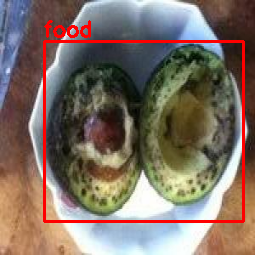

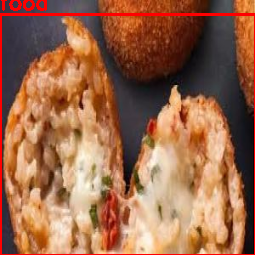

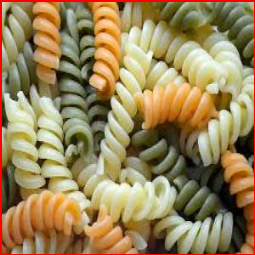

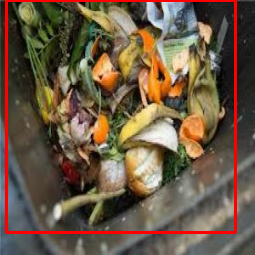

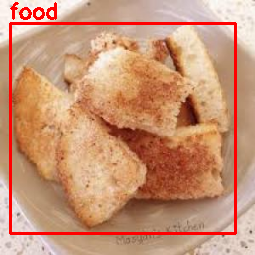

In [7]:
# The dataset class.
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []

        # Get all the image paths in sorted order.
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.dir_path, file_type)))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # Capture the image name and the full image path.
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # Read and preprocess the image.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # Capture the corresponding XML file for getting the annotations.
        annot_filename = os.path.splitext(image_name)[0] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # Original image width and height.
        image_width = image.shape[1]
        image_height = image.shape[0]

        # Box coordinates for xml files are extracted
        # and corrected for image size given.
        for member in root.findall('object'):
            # Get label and map the `classes`.
            labels.append(self.classes.index(member.find('name').text))

            # Left corner x-coordinates.
            xmin = int(member.find('bndbox').find('xmin').text)
            # Right corner x-coordinates.
            xmax = int(member.find('bndbox').find('xmax').text)
            # Left corner y-coordinates.
            ymin = int(member.find('bndbox').find('ymin').text)
            # Right corner y-coordinates.
            ymax = int(member.find('bndbox').find('ymax').text)

            # Resize the bounding boxes according
            # to resized image `width`, `height`.
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            # Check that all coordinates are within the image.
            if xmax_final > self.width:
                xmax_final = self.width
            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # Bounding box to tensor.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Area of the bounding boxes.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 \
            else torch.as_tensor(boxes, dtype=torch.float32)
        # No crowd instances.
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # Labels to tensor.
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Prepare the final `target` dictionary.
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # Apply the image transforms.
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        if np.isnan((target['boxes']).numpy()).any() or target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.zeros((0, 4), dtype=torch.int64)
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# Prepare the final datasets and data loaders.
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=False
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=False
    )
    return valid_loader


# execute `datasets.py`` using Python command from
# Terminal to visualize sample images
# USAGE: python datasets.py
if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = CustomDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")

    # function to visualize a single sample
    def visualize_sample(image, target):
        for box_num in range(len(target['boxes'])):
            box = target['boxes'][box_num]
            label = CLASSES[target['labels'][box_num]]
            normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
            # Convert the normalized image to 8-bit format for display
            display_image = normalized_image.astype(np.uint8)
            image = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)
            cv2.rectangle(
                image,
                (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                (0, 0, 255),
                2
            )
            cv2.putText(
                image,
                label,
                (int(box[0]), int(box[1]-5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 255),
                2
            )
        cv2_imshow(image)
        # cv2.waitKey(0)

    NUM_SAMPLES_TO_VISUALIZE = 5
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

In [8]:
plt.style.use('ggplot')

# This class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well.
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation mAP @0.5:0.95 IoU higher than the previous highest, then save the
    model state.
    """
    def __init__(
        self, best_valid_map=float(0)
    ):
        self.best_valid_map = best_valid_map

    def __call__(
        self,
        model,
        current_valid_map,
        epoch,
        OUT_DIR,
    ):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBEST VALIDATION mAP: {self.best_valid_map}")
            print(f"\nSAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, f"{OUT_DIR}/best_model_resnet101_sgd_0.01.pth")

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Define the training tranforms.
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.1),
        A.MotionBlur(blur_limit=3, p=0.1),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.ToGray(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(p=0.3),
        A.RandomGamma(p=0.3),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]],
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{OUT_DIR}/last_model_resnet101_sgd_0.01.pth')

def save_loss_plot(
    OUT_DIR,
    train_loss_list,
    x_label='iterations',
    y_label='train loss',
    save_name='train_loss'
):
    """
    Function to save both train loss graph.

    :param OUT_DIR: Path to save the graphs.
    :param train_loss_list: List containing the training loss values.
    """
    figure_1 = plt.figure(figsize=(10, 7), num=1, clear=True)
    train_ax = figure_1.add_subplot()
    train_ax.plot(train_loss_list, color='tab:blue')
    train_ax.set_xlabel(x_label)
    train_ax.set_ylabel(y_label)
    figure_1.savefig(f"{OUT_DIR}/{save_name}_resnet101_sgd_0.01.png")
    print('SAVING PLOTS COMPLETE...')

def save_mAP(OUT_DIR, map_05, map):
    """
    Saves the mAP@0.5 and mAP@0.5:0.95 per epoch.
    :param OUT_DIR: Path to save the graphs.
    :param map_05: List containing mAP values at 0.5 IoU.
    :param map: List containing mAP values at 0.5:0.95 IoU.
    """
    figure = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = figure.add_subplot()
    ax.plot(
        map_05, color='tab:orange', linestyle='-',
        label='mAP@0.5'
    )
    ax.plot(
        map, color='tab:red', linestyle='-',
        label='mAP@0.5:0.95'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('mAP')
    ax.legend()
    figure.savefig(f"{OUT_DIR}/map_resnet101_sgd_0.01.png")

Number of training samples: 560
Number of validation samples: 160

SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch #1 train loss: 29.318
Epoch #1 mAP@0.50:0.95: 0.0
Epoch #1 mAP@0.50: 0.0
Took 2.917 minutes for epoch 0
SAVING PLOTS COMPLETE...

EPOCH 2 of 75
Training


<ipython-input-9-1a573c822bb0>:152: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  figure = plt.figure(figsize=(10, 7), num=1, clear=True)


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #2 train loss: 11.645
Epoch #2 mAP@0.50:0.95: 0.002165036043152213
Epoch #2 mAP@0.50: 0.011791013181209564
Took 0.301 minutes for epoch 1

BEST VALIDATION mAP: 0.002165036043152213

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 75
Training


<ipython-input-9-1a573c822bb0>:137: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  figure_1 = plt.figure(figsize=(10, 7), num=1, clear=True)


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #3 train loss: 24.100
Epoch #3 mAP@0.50:0.95: 0.0011826609261333942
Epoch #3 mAP@0.50: 0.0060702236369252205
Took 0.301 minutes for epoch 2
SAVING PLOTS COMPLETE...

EPOCH 4 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #4 train loss: 13.917
Epoch #4 mAP@0.50:0.95: 0.058439578860998154
Epoch #4 mAP@0.50: 0.12204784899950027
Took 0.303 minutes for epoch 3

BEST VALIDATION mAP: 0.058439578860998154

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...

EPOCH 5 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #5 train loss: 12.038
Epoch #5 mAP@0.50:0.95: 0.09547055512666702
Epoch #5 mAP@0.50: 0.16725653409957886
Took 0.296 minutes for epoch 4

BEST VALIDATION mAP: 0.09547055512666702

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #6 train loss: 9.197
Epoch #6 mAP@0.50:0.95: 0.14060042798519135
Epoch #6 mAP@0.50: 0.2754133939743042
Took 0.300 minutes for epoch 5

BEST VALIDATION mAP: 0.14060042798519135

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...

EPOCH 7 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #7 train loss: 7.888
Epoch #7 mAP@0.50:0.95: 0.13081352412700653
Epoch #7 mAP@0.50: 0.23847752809524536
Took 0.305 minutes for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 8 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #8 train loss: 10.192
Epoch #8 mAP@0.50:0.95: 0.1287153661251068
Epoch #8 mAP@0.50: 0.23781272768974304
Took 0.316 minutes for epoch 7
SAVING PLOTS COMPLETE...

EPOCH 9 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #9 train loss: 6.821
Epoch #9 mAP@0.50:0.95: 0.1249009519815445
Epoch #9 mAP@0.50: 0.2765325605869293
Took 0.331 minutes for epoch 8
SAVING PLOTS COMPLETE...

EPOCH 10 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #10 train loss: 6.795
Epoch #10 mAP@0.50:0.95: 0.16391421854496002
Epoch #10 mAP@0.50: 0.2582980692386627
Took 0.321 minutes for epoch 9

BEST VALIDATION mAP: 0.16391421854496002

SAVING BEST MODEL FOR EPOCH: 10

SAVING PLOTS COMPLETE...

EPOCH 11 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #11 train loss: 6.581
Epoch #11 mAP@0.50:0.95: 0.186446875333786
Epoch #11 mAP@0.50: 0.2805787920951843
Took 0.327 minutes for epoch 10

BEST VALIDATION mAP: 0.186446875333786

SAVING BEST MODEL FOR EPOCH: 11

SAVING PLOTS COMPLETE...

EPOCH 12 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #12 train loss: 6.575
Epoch #12 mAP@0.50:0.95: 0.15087278187274933
Epoch #12 mAP@0.50: 0.29897448420524597
Took 0.324 minutes for epoch 11
SAVING PLOTS COMPLETE...

EPOCH 13 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #13 train loss: 6.455
Epoch #13 mAP@0.50:0.95: 0.10548591613769531
Epoch #13 mAP@0.50: 0.2977372407913208
Took 0.327 minutes for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 14 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #14 train loss: 6.612
Epoch #14 mAP@0.50:0.95: 0.185185968875885
Epoch #14 mAP@0.50: 0.2739490866661072
Took 0.335 minutes for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 15 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #15 train loss: 7.616
Epoch #15 mAP@0.50:0.95: 0.2038113921880722
Epoch #15 mAP@0.50: 0.29509299993515015
Took 0.320 minutes for epoch 14

BEST VALIDATION mAP: 0.2038113921880722

SAVING BEST MODEL FOR EPOCH: 15

SAVING PLOTS COMPLETE...

EPOCH 16 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #16 train loss: 6.550
Epoch #16 mAP@0.50:0.95: 0.15890157222747803
Epoch #16 mAP@0.50: 0.27363693714141846
Took 0.329 minutes for epoch 15
SAVING PLOTS COMPLETE...

EPOCH 17 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #17 train loss: 6.401
Epoch #17 mAP@0.50:0.95: 0.17745305597782135
Epoch #17 mAP@0.50: 0.28838303685188293
Took 0.312 minutes for epoch 16
SAVING PLOTS COMPLETE...

EPOCH 18 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #18 train loss: 6.450
Epoch #18 mAP@0.50:0.95: 0.18496805429458618
Epoch #18 mAP@0.50: 0.3015437424182892
Took 0.320 minutes for epoch 17
SAVING PLOTS COMPLETE...

EPOCH 19 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #19 train loss: 6.544
Epoch #19 mAP@0.50:0.95: 0.21111498773097992
Epoch #19 mAP@0.50: 0.34394770860671997
Took 0.334 minutes for epoch 18

BEST VALIDATION mAP: 0.21111498773097992

SAVING BEST MODEL FOR EPOCH: 19

SAVING PLOTS COMPLETE...

EPOCH 20 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #20 train loss: 6.410
Epoch #20 mAP@0.50:0.95: 0.15188661217689514
Epoch #20 mAP@0.50: 0.29300346970558167
Took 0.323 minutes for epoch 19
SAVING PLOTS COMPLETE...

EPOCH 21 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #21 train loss: 7.319
Epoch #21 mAP@0.50:0.95: 0.21273666620254517
Epoch #21 mAP@0.50: 0.29506736993789673
Took 0.323 minutes for epoch 20

BEST VALIDATION mAP: 0.21273666620254517

SAVING BEST MODEL FOR EPOCH: 21

SAVING PLOTS COMPLETE...

EPOCH 22 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #22 train loss: 6.327
Epoch #22 mAP@0.50:0.95: 0.1662570983171463
Epoch #22 mAP@0.50: 0.28484171628952026
Took 0.321 minutes for epoch 21
SAVING PLOTS COMPLETE...

EPOCH 23 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #23 train loss: 6.367
Epoch #23 mAP@0.50:0.95: 0.194566011428833
Epoch #23 mAP@0.50: 0.3002282977104187
Took 0.325 minutes for epoch 22
SAVING PLOTS COMPLETE...

EPOCH 24 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #24 train loss: 6.380
Epoch #24 mAP@0.50:0.95: 0.19413809478282928
Epoch #24 mAP@0.50: 0.29539167881011963
Took 0.322 minutes for epoch 23
SAVING PLOTS COMPLETE...

EPOCH 25 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #25 train loss: 6.087
Epoch #25 mAP@0.50:0.95: 0.2087557017803192
Epoch #25 mAP@0.50: 0.2899356782436371
Took 0.320 minutes for epoch 24
SAVING PLOTS COMPLETE...

EPOCH 26 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #26 train loss: 6.243
Epoch #26 mAP@0.50:0.95: 0.19671906530857086
Epoch #26 mAP@0.50: 0.2738409638404846
Took 0.323 minutes for epoch 25
SAVING PLOTS COMPLETE...

EPOCH 27 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #27 train loss: 6.168
Epoch #27 mAP@0.50:0.95: 0.21217522025108337
Epoch #27 mAP@0.50: 0.28848931193351746
Took 0.330 minutes for epoch 26
SAVING PLOTS COMPLETE...

EPOCH 28 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #28 train loss: 6.142
Epoch #28 mAP@0.50:0.95: 0.21023936569690704
Epoch #28 mAP@0.50: 0.2897227108478546
Took 0.321 minutes for epoch 27
SAVING PLOTS COMPLETE...

EPOCH 29 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #29 train loss: 6.080
Epoch #29 mAP@0.50:0.95: 0.15908120572566986
Epoch #29 mAP@0.50: 0.2760721743106842
Took 0.319 minutes for epoch 28
SAVING PLOTS COMPLETE...

EPOCH 30 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #30 train loss: 5.992
Epoch #30 mAP@0.50:0.95: 0.20972661674022675
Epoch #30 mAP@0.50: 0.2964983582496643
Took 0.312 minutes for epoch 29
SAVING PLOTS COMPLETE...

EPOCH 31 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #31 train loss: 6.084
Epoch #31 mAP@0.50:0.95: 0.2221611589193344
Epoch #31 mAP@0.50: 0.3179953098297119
Took 0.321 minutes for epoch 30

BEST VALIDATION mAP: 0.2221611589193344

SAVING BEST MODEL FOR EPOCH: 31

SAVING PLOTS COMPLETE...

EPOCH 32 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #32 train loss: 6.070
Epoch #32 mAP@0.50:0.95: 0.1706627607345581
Epoch #32 mAP@0.50: 0.29030168056488037
Took 0.315 minutes for epoch 31
SAVING PLOTS COMPLETE...

EPOCH 33 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #33 train loss: 6.004
Epoch #33 mAP@0.50:0.95: 0.17876261472702026
Epoch #33 mAP@0.50: 0.2797143757343292
Took 0.331 minutes for epoch 32
SAVING PLOTS COMPLETE...

EPOCH 34 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #34 train loss: 5.955
Epoch #34 mAP@0.50:0.95: 0.21719896793365479
Epoch #34 mAP@0.50: 0.3018054664134979
Took 0.318 minutes for epoch 33
SAVING PLOTS COMPLETE...

EPOCH 35 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #35 train loss: 5.978
Epoch #35 mAP@0.50:0.95: 0.19308434426784515
Epoch #35 mAP@0.50: 0.27131301164627075
Took 0.313 minutes for epoch 34
SAVING PLOTS COMPLETE...

EPOCH 36 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #36 train loss: 5.852
Epoch #36 mAP@0.50:0.95: 0.17680595815181732
Epoch #36 mAP@0.50: 0.25340795516967773
Took 0.321 minutes for epoch 35
SAVING PLOTS COMPLETE...

EPOCH 37 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #37 train loss: 7.192
Epoch #37 mAP@0.50:0.95: 0.14382889866828918
Epoch #37 mAP@0.50: 0.2159789502620697
Took 0.318 minutes for epoch 36
SAVING PLOTS COMPLETE...

EPOCH 38 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #38 train loss: 6.204
Epoch #38 mAP@0.50:0.95: 0.12349296361207962
Epoch #38 mAP@0.50: 0.25814366340637207
Took 0.323 minutes for epoch 37
SAVING PLOTS COMPLETE...

EPOCH 39 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #39 train loss: 5.964
Epoch #39 mAP@0.50:0.95: 0.2029685229063034
Epoch #39 mAP@0.50: 0.30057236552238464
Took 0.310 minutes for epoch 38
SAVING PLOTS COMPLETE...

EPOCH 40 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #40 train loss: 5.958
Epoch #40 mAP@0.50:0.95: 0.19928188621997833
Epoch #40 mAP@0.50: 0.29477643966674805
Took 0.312 minutes for epoch 39
SAVING PLOTS COMPLETE...

EPOCH 41 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #41 train loss: 6.003
Epoch #41 mAP@0.50:0.95: 0.1722675859928131
Epoch #41 mAP@0.50: 0.2462603598833084
Took 0.311 minutes for epoch 40
SAVING PLOTS COMPLETE...

EPOCH 42 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #42 train loss: 5.877
Epoch #42 mAP@0.50:0.95: 0.18196053802967072
Epoch #42 mAP@0.50: 0.296052485704422
Took 0.306 minutes for epoch 41
SAVING PLOTS COMPLETE...

EPOCH 43 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #43 train loss: 5.892
Epoch #43 mAP@0.50:0.95: 0.2075825035572052
Epoch #43 mAP@0.50: 0.2915813624858856
Took 0.318 minutes for epoch 42
SAVING PLOTS COMPLETE...

EPOCH 44 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #44 train loss: 5.886
Epoch #44 mAP@0.50:0.95: 0.2022855281829834
Epoch #44 mAP@0.50: 0.3020522892475128
Took 0.314 minutes for epoch 43
SAVING PLOTS COMPLETE...

EPOCH 45 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #45 train loss: 6.133
Epoch #45 mAP@0.50:0.95: 0.21140405535697937
Epoch #45 mAP@0.50: 0.2978595197200775
Took 0.325 minutes for epoch 44
SAVING PLOTS COMPLETE...

EPOCH 46 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #46 train loss: 5.792
Epoch #46 mAP@0.50:0.95: 0.2112794667482376
Epoch #46 mAP@0.50: 0.31023281812667847
Took 0.311 minutes for epoch 45
SAVING PLOTS COMPLETE...

EPOCH 47 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #47 train loss: 5.753
Epoch #47 mAP@0.50:0.95: 0.18356697261333466
Epoch #47 mAP@0.50: 0.3023701012134552
Took 0.330 minutes for epoch 46
SAVING PLOTS COMPLETE...

EPOCH 48 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #48 train loss: 5.735
Epoch #48 mAP@0.50:0.95: 0.19761455059051514
Epoch #48 mAP@0.50: 0.30485913157463074
Took 0.312 minutes for epoch 47
SAVING PLOTS COMPLETE...

EPOCH 49 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #49 train loss: 5.676
Epoch #49 mAP@0.50:0.95: 0.20514708757400513
Epoch #49 mAP@0.50: 0.3005700409412384
Took 0.310 minutes for epoch 48
SAVING PLOTS COMPLETE...

EPOCH 50 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #50 train loss: 5.692
Epoch #50 mAP@0.50:0.95: 0.2050088793039322
Epoch #50 mAP@0.50: 0.2994820773601532
Took 0.316 minutes for epoch 49
SAVING PLOTS COMPLETE...

EPOCH 51 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #51 train loss: 5.684
Epoch #51 mAP@0.50:0.95: 0.20476475358009338
Epoch #51 mAP@0.50: 0.30482304096221924
Took 0.305 minutes for epoch 50
SAVING PLOTS COMPLETE...

EPOCH 52 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #52 train loss: 5.613
Epoch #52 mAP@0.50:0.95: 0.2026403397321701
Epoch #52 mAP@0.50: 0.2948775589466095
Took 0.316 minutes for epoch 51
SAVING PLOTS COMPLETE...

EPOCH 53 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #53 train loss: 5.697
Epoch #53 mAP@0.50:0.95: 0.19696128368377686
Epoch #53 mAP@0.50: 0.29169484972953796
Took 0.313 minutes for epoch 52
SAVING PLOTS COMPLETE...

EPOCH 54 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #54 train loss: 5.708
Epoch #54 mAP@0.50:0.95: 0.19508403539657593
Epoch #54 mAP@0.50: 0.29187464714050293
Took 0.317 minutes for epoch 53
SAVING PLOTS COMPLETE...

EPOCH 55 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #55 train loss: 5.761
Epoch #55 mAP@0.50:0.95: 0.20126862823963165
Epoch #55 mAP@0.50: 0.3006143569946289
Took 0.309 minutes for epoch 54
SAVING PLOTS COMPLETE...

EPOCH 56 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #56 train loss: 5.593
Epoch #56 mAP@0.50:0.95: 0.1943437159061432
Epoch #56 mAP@0.50: 0.28104734420776367
Took 0.314 minutes for epoch 55
SAVING PLOTS COMPLETE...

EPOCH 57 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #57 train loss: 5.734
Epoch #57 mAP@0.50:0.95: 0.20034334063529968
Epoch #57 mAP@0.50: 0.2962252199649811
Took 0.312 minutes for epoch 56
SAVING PLOTS COMPLETE...

EPOCH 58 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #58 train loss: 5.790
Epoch #58 mAP@0.50:0.95: 0.19348487257957458
Epoch #58 mAP@0.50: 0.2904770076274872
Took 0.301 minutes for epoch 57
SAVING PLOTS COMPLETE...

EPOCH 59 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #59 train loss: 5.618
Epoch #59 mAP@0.50:0.95: 0.19350922107696533
Epoch #59 mAP@0.50: 0.2853821814060211
Took 0.310 minutes for epoch 58
SAVING PLOTS COMPLETE...

EPOCH 60 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #60 train loss: 5.673
Epoch #60 mAP@0.50:0.95: 0.19569791853427887
Epoch #60 mAP@0.50: 0.29569876194000244
Took 0.319 minutes for epoch 59
SAVING PLOTS COMPLETE...

EPOCH 61 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #61 train loss: 5.727
Epoch #61 mAP@0.50:0.95: 0.20599061250686646
Epoch #61 mAP@0.50: 0.29526615142822266
Took 0.317 minutes for epoch 60
SAVING PLOTS COMPLETE...

EPOCH 62 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #62 train loss: 5.617
Epoch #62 mAP@0.50:0.95: 0.19414663314819336
Epoch #62 mAP@0.50: 0.3009931743144989
Took 0.314 minutes for epoch 61
SAVING PLOTS COMPLETE...

EPOCH 63 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #63 train loss: 5.662
Epoch #63 mAP@0.50:0.95: 0.1953291893005371
Epoch #63 mAP@0.50: 0.3033939301967621
Took 0.318 minutes for epoch 62
SAVING PLOTS COMPLETE...

EPOCH 64 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #64 train loss: 5.691
Epoch #64 mAP@0.50:0.95: 0.19897311925888062
Epoch #64 mAP@0.50: 0.29312705993652344
Took 0.316 minutes for epoch 63
SAVING PLOTS COMPLETE...

EPOCH 65 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #65 train loss: 5.543
Epoch #65 mAP@0.50:0.95: 0.197492778301239
Epoch #65 mAP@0.50: 0.2968645393848419
Took 0.325 minutes for epoch 64
SAVING PLOTS COMPLETE...

EPOCH 66 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #66 train loss: 5.609
Epoch #66 mAP@0.50:0.95: 0.20565171539783478
Epoch #66 mAP@0.50: 0.29202502965927124
Took 0.314 minutes for epoch 65
SAVING PLOTS COMPLETE...

EPOCH 67 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #67 train loss: 5.698
Epoch #67 mAP@0.50:0.95: 0.20786550641059875
Epoch #67 mAP@0.50: 0.2971731126308441
Took 0.317 minutes for epoch 66
SAVING PLOTS COMPLETE...

EPOCH 68 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #68 train loss: 5.675
Epoch #68 mAP@0.50:0.95: 0.19772367179393768
Epoch #68 mAP@0.50: 0.28749004006385803
Took 0.301 minutes for epoch 67
SAVING PLOTS COMPLETE...

EPOCH 69 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #69 train loss: 5.676
Epoch #69 mAP@0.50:0.95: 0.2108818143606186
Epoch #69 mAP@0.50: 0.29989132285118103
Took 0.302 minutes for epoch 68
SAVING PLOTS COMPLETE...

EPOCH 70 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #70 train loss: 5.656
Epoch #70 mAP@0.50:0.95: 0.2024005800485611
Epoch #70 mAP@0.50: 0.2712993621826172
Took 0.307 minutes for epoch 69
SAVING PLOTS COMPLETE...

EPOCH 71 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #71 train loss: 5.574
Epoch #71 mAP@0.50:0.95: 0.18073400855064392
Epoch #71 mAP@0.50: 0.2846936583518982
Took 0.309 minutes for epoch 70
SAVING PLOTS COMPLETE...

EPOCH 72 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #72 train loss: 5.665
Epoch #72 mAP@0.50:0.95: 0.19403928518295288
Epoch #72 mAP@0.50: 0.2843807339668274
Took 0.313 minutes for epoch 71
SAVING PLOTS COMPLETE...

EPOCH 73 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #73 train loss: 5.576
Epoch #73 mAP@0.50:0.95: 0.20368759334087372
Epoch #73 mAP@0.50: 0.3013431131839752
Took 0.312 minutes for epoch 72
SAVING PLOTS COMPLETE...

EPOCH 74 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #74 train loss: 5.593
Epoch #74 mAP@0.50:0.95: 0.20307953655719757
Epoch #74 mAP@0.50: 0.28710031509399414
Took 0.311 minutes for epoch 73
SAVING PLOTS COMPLETE...

EPOCH 75 of 75
Training


  0%|          | 0/35 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #75 train loss: 5.549
Epoch #75 mAP@0.50:0.95: 0.20429468154907227
Epoch #75 mAP@0.50: 0.2777947783470154
Took 0.313 minutes for epoch 74
SAVING PLOTS COMPLETE...


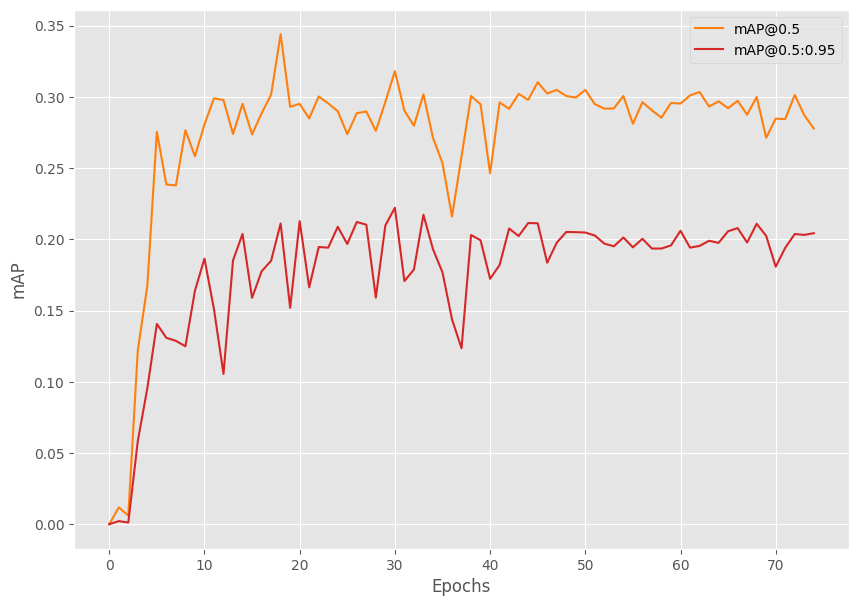

In [ ]:
plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value

# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

if __name__ == '__main__':
    os.makedirs('outputs', exist_ok=True)
    train_dataset = create_train_dataset(TRAIN_DIR)
    valid_dataset = create_valid_dataset(VALID_DIR)
    train_loader = create_train_loader(train_dataset, NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")

    # Initialize the model and move to the computation device.
    model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO)
    model = model.to(DEVICE)

    # # Weight initialization
    # def init_weights(m):
    #     if isinstance(m, nn.Conv2d):
    #         torch.nn.init.xavier_uniform_(m.weight)
    #         if m.bias is not None:
    #             torch.nn.init.zeros_(m.bias)

    # model.apply(init_weights)

    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=0.01, momentum=0.9, nesterov=True #learning rate
    )
    scheduler = MultiStepLR(
        optimizer=optimizer, milestones=[45], gamma=0.1, verbose=True
    )

    # To monitor training loss
    train_loss_hist = Averager()
    # To store training loss and mAP values.
    train_loss_list = []
    map_50_list = []
    map_list = []

    # Mame to save the trained model with.
    MODEL_NAME = 'model'

    # Whether to show transformed images from data loader or not.
    if VISUALIZE_TRANSFORMED_IMAGES:
        show_tranformed_image(train_loader)

    # To save best model.
    save_best_model = SaveBestModel()

    # Training loop.
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # Reset the training loss histories for the current epoch.
        train_loss_hist.reset()

        # Start timer and carry out training and validation.
        start = time.time()
        train_loss = train(train_loader, model)
        metric_summary = validate(valid_loader, model)
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
        print(f"Epoch #{epoch+1} mAP@0.50:0.95: {metric_summary['map']}")
        print(f"Epoch #{epoch+1} mAP@0.50: {metric_summary['map_50']}")
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

        train_loss_list.append(train_loss)
        map_50_list.append(metric_summary['map_50'])
        map_list.append(metric_summary['map'])

        # save the best model till now.
        save_best_model(
            model, float(metric_summary['map']), epoch, 'outputs'
        )
        # Save the current epoch model.
        save_model(epoch, model, optimizer)

        # Save loss plot.
        save_loss_plot(OUT_DIR, train_loss_list)

        # Save mAP plot.
        save_mAP(OUT_DIR, map_50_list, map_list)
        scheduler.step()

<ipython-input-9-2db0ef682f0a>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_res

Validating


  0%|          | 0/5 [00:00<?, ?it/s]

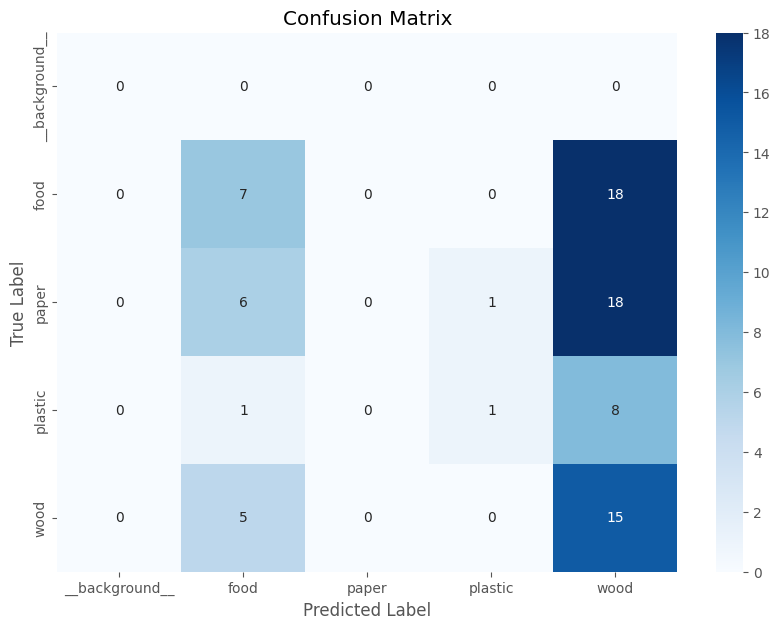

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


TP: 3990, TN: 51864, FP: 11968, FN: 11968
Precision: 25.00
Recall: 25.00
F1 Score: 25.0031
Class 0 - Average Precision (AP): Not available or NaN
Class 1 - Average Precision (AP): Not available or NaN
Class 2 - Average Precision (AP): Not available or NaN
Class 3 - Average Precision (AP): Not available or NaN
mAP_50: 30.705
mAP_50_95: 12.473


In [9]:
# Evaluation function
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []

    # Initialize TP, TN, FP, FN
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    # Inisialisasi confusion matrix
    conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)

            true_labels = targets[i]['labels'].detach().cpu().numpy()
            pred_labels = outputs[i]['labels'].detach().cpu().numpy()

            # Check if pred_labels is empty before iterating
            if len(pred_labels) > 0:
                # Update confusion matrix
                for i in range(len(true_labels)):
                    true_class = true_labels[i]
                    pred_class = pred_labels[i]
                    conf_matrix[true_class, pred_class] += 1

                # Hitung TP, TN, FN, FP untuk setiap kelas
                for class_id in range(NUM_CLASSES):
                    TP += np.sum((pred_labels == class_id) & (true_labels == class_id))
                    TN += np.sum((pred_labels != class_id) & (true_labels != class_id))
                    FP += np.sum((pred_labels == class_id) & (true_labels != class_id))
                    FN += np.sum((pred_labels != class_id) & (true_labels == class_id))

        #####################################

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    metric = MeanAveragePrecision(class_metrics=True) # Enable class metrics
    metric.update(preds, target)
    metric_summary = metric.compute()

    # Cetak hasil TP, TN, FN, FP
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

    # Calculate F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Precision: {precision *100:.2f}")
    print(f"Recall: {recall *100:.2f}")
    print(f"F1 Score: {f1_score *100:.4f}")

    # Check if 'map_per_class' is present and iterable
    if 'map_per_class' in metric_summary and isinstance(metric_summary['map_per_class'], (list, tuple, torch.Tensor)):
        class_names = ['__background__', 'food', 'paper', 'plastic', 'wood']  # Your class names
        for class_idx, ap in enumerate(metric_summary['map_per_class']):
            if not torch.isnan(ap) and ap.dim() > 0: # Check for NaN and 0-d tensors
                print(f"Class {class_idx} - Average Precision (AP): {ap:.4f}")
            else:
                print(f"Class {class_idx} - Average Precision (AP): Not available or NaN")
    else:
        print("Per-class mAP not available in metric_summary")

    # Return TP, TN, FP, FN along with other metrics
    metric_summary['TP'] = TP
    metric_summary['TN'] = TN
    metric_summary['FP'] = FP
    metric_summary['FN'] = FN
    metric_summary['F1'] = f1_score # Add F1 score to the dictionary

    return metric_summary

if __name__ == '__main__':
    # Load the best model and trained weights.
    model = create_model(num_classes=NUM_CLASSES, size=640)
    # checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_resnet101_sgd_0.01.pth')
    checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_resnet101_sgd_0.01.pth', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE).eval()

    test_dataset = create_valid_dataset(
        '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/test'
    )
    test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

    metric_summary = validate(test_loader, model)
    print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
    print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

In [ ]:
np.random.seed(42)

# Definisikan argumen secara manual untuk Colab
args = {
    'input': '/content/drive/MyDrive/Skripsi/CobaSkripsi7/data/test',  # Path ke folder input
    'imgsz': 640,  # Ukuran gambar yang diinginkan
    'threshold': 0.25  # Threshold deteksi
}

os.makedirs('/content/drive/MyDrive/Skripsi/CobaSkripsi7/inference_outputs/images_resnet101_sgd_0.01', exist_ok=True)

# Define COLORS and CLASSES
COLORS = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]  # Tambahkan warna sesuai kebutuhan
CLASSES = ['__background__', 'food', 'paper', 'plastic', 'wood']  # Sesuaikan dengan dataset Anda

# Load model terbaik
model = create_model(num_classes=NUM_CLASSES, size=640)
checkpoint = torch.load('/content/drive/MyDrive/Skripsi/CobaSkripsi7/outputs/best_model_resnet101_sgd_0.01.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Path ke folder gambar uji
DIR_TEST = args['input']
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

for i in range(len(test_images)):
    # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    if args['imgsz'] is not None:
        image = cv2.resize(image, (args['imgsz'], args['imgsz']))
    print(image.shape)
    # BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Make the pixel range between 0 and 1.
    image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor.
    # image_input = torch.tensor(image_input, dtype=torch.float).to(DEVICE) # Using DEVICE instead of .cuda()
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)
    start_time = time.time()
    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
    end_time = time.time()

    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Total FPS till current frame.
    total_fps += fps
    frame_count += 1

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`.
        boxes = boxes[scores >= args['threshold']].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Draw the bounding boxes and write the class name on top of it.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            # Recale boxes.
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            cv2.rectangle(orig_image,
                        (xmin, ymin),
                        (xmax, ymax),
                        color[::-1],
                        3)
            cv2.putText(orig_image,
                        class_name,
                        (xmin, ymin-5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.8,
                        color[::-1],
                        2,
                        lineType=cv2.LINE_AA)

        # Menampilkan hasil prediksi
        cv2_imshow(orig_image)
        cv2.imwrite(f"/content/drive/MyDrive/Skripsi/CobaSkripsi7/inference_outputs/images_resnet101_sgd_0.01/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
# cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Output hidden; open in https://colab.research.google.com to view.